In [78]:
from sklearn import datasets, linear_model,preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from file_reader import read_file
from math import sqrt
import random


In [153]:
class MultiClassLogisticRegression:

    def __init__(self, X, y, random_seed=10):
        np.random.seed(random_seed)
        self.random_seed = random_seed
        self.loss = []
        self.classes = np.unique(y)
        self.class_labels = {c: i for i, c in enumerate(self.classes)}
        self.weight = np.random.rand(len(self.classes), X.shape[1])
        self.y_true = self.one_hot_encoding(y)
        self.epsilon = 1e-16     # Small epsilon value to prevent numerical instability
 
    def one_hot_encoding(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]

    def predict(self, X, w):
        z = np.dot(X, w.T)
        return self.softmax(z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred):

        y_pred = np.clip(y_pred, self.epsilon, 1 - self.epsilon)  # Clip probabilities to avoid extreme values
        return -(np.sum(self.y_true * np.log(y_pred))) / len(self.y_true)        
    
    def objective_f(self, probs, weight, lam, n):
        loss = self.cross_entropy_loss(probs) 
        l2 = lam * np.sum(np.square(weight)) 
        return loss + l2

    def cross_entropy_loss_gradient(self, X, y_pred, weight, lam):
        return -(np.dot(X.T, (self.y_true - y_pred))).T / len(X)   + 2 * lam * weight 
    
    def cross_entropy_hessian(self, X, lam):
        n_samples, n_features = X.shape
        y_pred = self.predict(X, self.weight)
        n_classes = y_pred.shape[1]
        H = np.zeros((n_classes, n_classes))

        for n in range(n_samples):
            p_n = y_pred[n]
            x_n = X[n]
            ppT = np.dot(p_n, p_n.reshape(-1,1))
            xxT = np.dot(x_n, x_n.reshape(-1,1))
            np.kron( np.diag(p_n * (1-p_n)) - ppT, xxT)          
            
        return H / n_samples + lam * np.eye(n_classes)

    def predict_classes(self, X):
        probs = self.predict(X, self.weight)
        return np.vectorize(lambda c: self.classes[c] )(np.argmax(probs, axis=1)) 
    
    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)
    
    def armijo_line_search(self, X, gradient, direction, current_loss, alpha, rho, c, lam):

        while alpha > 1e-8:
            w_next = self.weight + alpha * direction

            y_pred = self.predict(X, w_next)
            new_loss = self.objective_f(y_pred, w_next, lam, len(X))

            armijo_condition = new_loss <= current_loss + c * alpha * np.sum(gradient * direction)
            if armijo_condition:
                break
            else:
                alpha *= rho
                
        return alpha

    def gradient_descend(self, X, max_epoch, alpha, rho, c, lam):
        N = len(X)

        for _ in range(max_epoch):
            y_pred = self.predict(X, self.weight)
            loss = self.objective_f(y_pred, self.weight, lam, N)
            gradient = self.cross_entropy_loss_gradient(X, y_pred, self.weight, lam) 
            direction = - gradient 
            lr = self.armijo_line_search(X, gradient, direction, loss , alpha, rho, c, lam)
            self.weight = self.weight + lr * direction
            self.loss.append(loss)
            
            
    def cauchy_point(self, G, B, trust_radius, N):

        
        gT_b_g  = np.sum(np.dot(G.T, np.dot(B, G))) / N
        g_norm = np.linalg.norm(G)
                
        if gT_b_g <= 0:
            alpha = trust_radius / g_norm
        else:
            alpha =  min(trust_radius / g_norm , g_norm**2 / gT_b_g )
        
        return - alpha * G
    
    def m(self, fk, G, B, p):

        return fk + np.mean(np.sum((np.dot(G.T, p) + 0.5 * np.dot(p.T, np.dot(B, p))), axis = 1)) 

    def trust_region(self, X, trust_radius, max_trust_radius, max_epoch, eta1, eta2 , gamma1, gamma2,  lam ):
    
        N, n_features = X.shape
    
        for k in range(max_epoch):
            probs = self.predict(X, self.weight)
            G = self.cross_entropy_loss_gradient(X, probs, self.weight, lam) 
            H = self.cross_entropy_hessian(X, lam)

            fx = self.objective_f(probs, self.weight, lam, N)
            pk = self.cauchy_point(G, H, trust_radius, n_features)
            
            self.loss.append(fx)
            
            new_weight = self.weight + pk
            new_probs = self.predict(X, new_weight)
            new_fx = self.objective_f(new_probs, new_weight, lam, N)
            
            # Actual reduction.
            act_red = fx - new_fx
            # Predicted reduction.
            pred_red = self.m(fx, G, H, np.zeros(pk.shape)) - self.m(fx, G, H, pk)

            if pred_red == 0.0:
                rho = eta1 + 1
            else:
                 rho = act_red / pred_red
            # print(act_red, pred_red, rho )

                
            # Choose the weight for the next iteration.
            if rho >= eta1:
                self.weight += pk
                
            if rho >= eta2:
                trust_radius = random.uniform(trust_radius, max_trust_radius)
            elif rho >= eta1 or rho < eta2:
                trust_radius = random.uniform(gamma2 * trust_radius, trust_radius)
            elif rho < eta1:
                trust_radius = random.uniform(gamma1 * trust_radius, gamma2 * trust_radius)
        
         
            

In [80]:
def plot(loss_1, loss_2):
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(range(1, len(loss_1) +1 ), loss_1)
    plt.plot(range(1, len(loss_2) +1 ), loss_2)
    
    plt.title("Development of loss during Training")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    
    plt.legend(['gradient descend', 'trust region']) 
    plt.show()

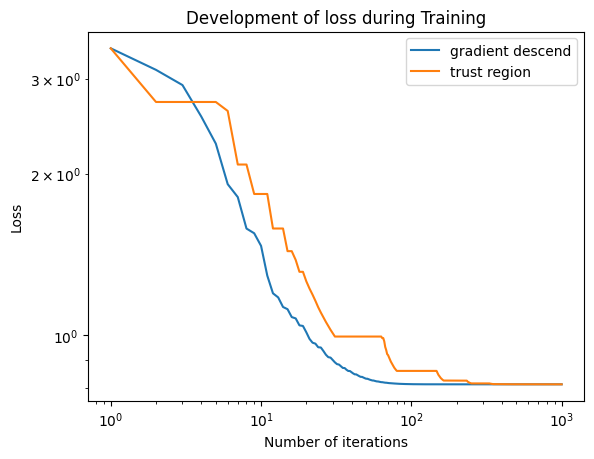

In [154]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.8
ARMIJO_ALPHA = 0.5
ARMIJO_C = 0.01
LAMBDA = 1/4

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.1
ETA2 = 0.8
GAMMA1 =0.2
GAMA2 = 0.8
lr1= MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2= MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH,  ETA1 , ETA2, GAMMA1, GAMA2, LAMBDA)
plot(lr1.loss, lr2.loss)


In [82]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = MAX_EPOCH )
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))


0.7428571428571429 0.9619047619047619
0.7428571428571429 0.9619047619047619


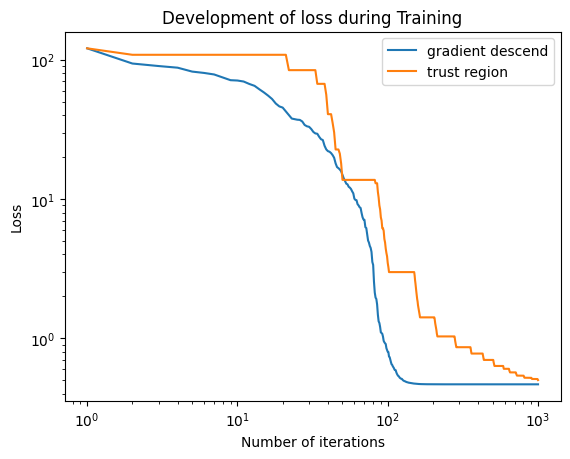

In [155]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.9
ARMIJO_ALPHA = 0.5
ARMIJO_C = 1e-4
LAMBDA = 1/2

X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.2
ETA2 = 0.8
GAMMA1 =0.2
GAMA2 = 0.8
lr1= MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2= MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH,  ETA1 , ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss)

In [84]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = 10000 )
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))


0.9483306836248012 0.9475357710651828
0.09538950715421304 0.9475357710651828


6.51269409665835 4.834084610529892 1.3472445398394581
-93.6327465151522 47.663535541453264 -1.9644523942987662
-93.6327465151522 47.663535541453264 -1.9644523942987662
-32.85916849374404 54.992332400785784 -0.5975227283372058
10.083530436026155 55.39517523563424 0.18202903760361586
20.186186684520177 53.83961235180311 0.37493187270030803
35.926692521755164 44.13760393502368 0.8139701596544288
-40.89875932933941 12.593406707305556 -3.24763269224154
-40.89875932933941 12.593406707305556 -3.24763269224154
-40.89875932933941 12.593406707305556 -3.24763269224154
-40.89875932933941 12.593406707305556 -3.24763269224154
-40.89875932933941 12.593406707305556 -3.24763269224154
-40.89875932933941 12.593406707305556 -3.24763269224154
-40.89875932933941 12.593406707305556 -3.24763269224154
-32.23727964899629 12.58340928112043 -2.561887555971308
-24.335730677457725 12.111750992425312 -2.0092660997305254
-12.564120737579128 10.318564082793285 -1.217622979008331
-4.0931290730375185 7.380016008759329 -

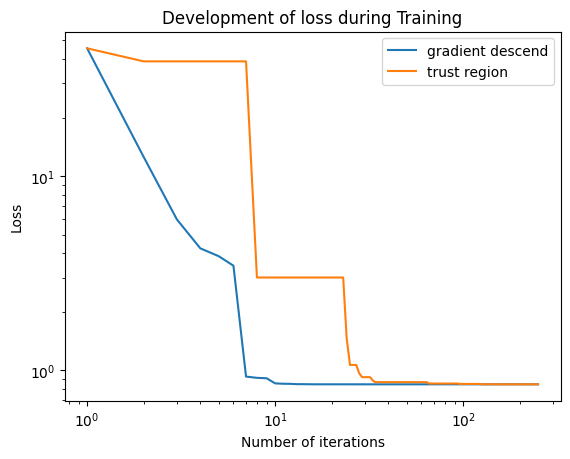

In [85]:
MAX_EPOCH = 250
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 1
ARMIJO_C = 1e-4
LAMBDA = 1/4
X_train, y_train = read_file('datasets/dna/dna_train.txt', 180)
X_test , y_test = read_file('datasets/dna/dna_test.txt', 180)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.5
ETA2 = 0.8
GAMMA1 = 0.3
GAMA2 = 0.6
lr1= MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2= MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH,  ETA1 , ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss)

In [86]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))

0.7883642495784149 0.9418212478920742
0.7883642495784149 0.9418212478920742


3.9748822958727565 3.0307212295603616 1.3115301589283272
-30.45832251760435 17.785487117794123 -1.7125379988682592
-30.45832251760435 17.785487117794123 -1.7125379988682592
-30.45832251760435 17.785487117794123 -1.7125379988682592
-8.111166317793678 20.18787250014753 -0.4017841066578166
12.643222450898666 16.176936975054232 0.7815584909797969
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5.958038024750875
-7.745981365457957 1.300089279940747 -5

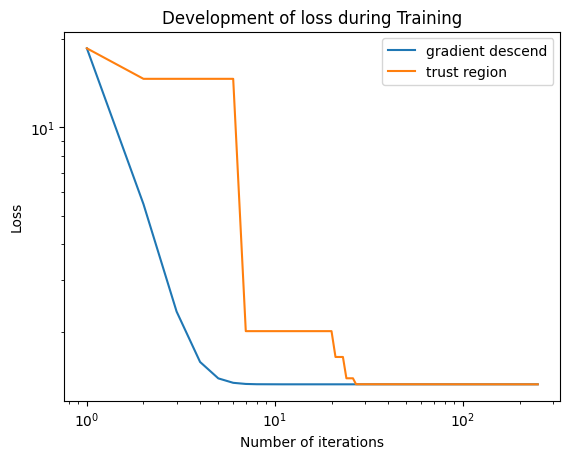

In [87]:
X_train, y_train = read_file('datasets/segment/segment_train.txt', 36)
X_test , y_test = read_file('datasets/segment/segment_test.txt', 36)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.25
ETA2 = 0.75
GAMMA1 = 0.25
GAMA2 = 0.5
lr1= MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2= MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH,  ETA1 , ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss)

In [88]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)
print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test))
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test))

0.6710582235444114 0.7879303017424565
0.6710582235444114 0.7879303017424565
